In [17]:
import pandas as pd 

df_train = pd.read_csv('train.csv')
df_valid = pd.read_csv('valid.csv')

df = df_train.append(df_valid, ignore_index=True)
df_test = pd.read_csv('test.csv')

df= df.append(df_test, ignore_index=True)
df.head()

/var/folders/23/3qngh5250tv735v94vz5s2fw0000gn/T/ipykernel_12881/2229079519.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_train.append(df_valid, ignore_index=True)
/var/folders/23/3qngh5250tv735v94vz5s2fw0000gn/T/ipykernel_12881/2229079519.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df= df.append(df_test, ignore_index=True)


,id,text,label
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,436,Ibu pernah bekerja di grab indonesia,neutral
3,394,Paling suka banget makan siang di sini ayam sa...,positive
4,592,Pelayanan bus DAMRI sangat baik,positive


In [18]:
df.label.value_counts()

negative    383
positive    378
neutral     239
Name: label, dtype: int64

In [19]:
import re 

def lower(text):
    return text.lower()

def rmv_unn(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def rmv_nonalpha(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

def preprocess(text):
    text = lower(text) # 1
    text = rmv_nonalpha(text) # 2
    text = rmv_unn(text) # 2
    return text

df['text_clean'] = df.text.apply(preprocess)
df.head()

,id,text,label,text_clean
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral,nikmati cicilan 0 hingga 12 bulan untuk pemesa...
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,positive,kue kue yang disajikan bikin saya bernostalgia...
2,436,Ibu pernah bekerja di grab indonesia,neutral,ibu pernah bekerja di grab indonesia
3,394,Paling suka banget makan siang di sini ayam sa...,positive,paling suka banget makan siang di sini ayam sa...
4,592,Pelayanan bus DAMRI sangat baik,positive,pelayanan bus damri sangat baik


In [20]:
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()

neg_label = df.loc[df['label']=='negative'].label.tolist()
neu_label = df.loc[df['label']=='neutral'].label.tolist()
pos_label = df.loc[df['label']=='positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" %(len(pos), len(neu), len(neg)))
print("Total data: %s" %len(total_data))

Pos: 378, Neu: 239, Neg: 383
Total data: 1000


In [21]:
import pickle 
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open ('tokenizer.pickle', 'wb') as handle: 
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print("tokenizer.pickle has been created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
print(X)
with open ('x_pad_sequences.pickle', 'wb') as handle: 
  pickle.dump(X, handle,protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has been created!')

tokenizer.pickle has been created!
[[   0    0    0 ...   49   14  107]
 [   0    0    0 ...    7   12  570]
 [   0    0    0 ... 1884   16  106]
 ...
 [   0    0    0 ...  923   14 1777]
 [   0    0    0 ...  114  189 4265]
 [   0    0    0 ... 4269  123  441]]
x_pad_sequences.pickle has been created!


In [22]:
Y = pd.get_dummies(labels)
Y = Y.values
print(Y)

with open('y_labels.pickle', 'wb') as handle: 
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has been created!')

[[0 0 1]
 [0 0 1]
 [0 0 1]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
y_labels.pickle has been created!


In [23]:
from sklearn.model_selection import train_test_split

file = open('x_pad_sequences.pickle', 'rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle', 'rb')
Y= pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

In [8]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten 
from tensorflow.keras import backend as K


In [26]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 78, 100)           10000000  
                                                                 
 lstm_8 (LSTM)               (None, 64)                42240     
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


2022-12-02 00:02:40.222227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:02:40.406030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:02:40.579548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - ETA: 0s - loss: 0.9211 - accuracy: 0.5637

2022-12-02 00:02:45.838817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:02:45.901091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 7s 69ms/step - loss: 0.9211 - accuracy: 0.5637 - val_loss: 0.8172 - val_accuracy: 0.6900
Epoch 2/10
80/80 [==============================] - 5s 61ms/step - loss: 0.4985 - accuracy: 0.8262 - val_loss: 0.6652 - val_accuracy: 0.7800
Epoch 3/10
80/80 [==============================] - 5s 58ms/step - loss: 0.1736 - accuracy: 0.9500 - val_loss: 0.6085 - val_accuracy: 0.7800
Epoch 4/10
80/80 [==============================] - 5s 59ms/step - loss: 0.0451 - accuracy: 0.9925 - val_loss: 0.6116 - val_accuracy: 0.8200
Epoch 5/10
80/80 [==============================] - 5s 58ms/step - loss: 0.0323 - accuracy: 0.9912 - val_loss: 0.6753 - val_accuracy: 0.7850
Epoch 6/10
80/80 [==============================] - 5s 58ms/step - loss: 0.0240 - accuracy: 0.9962 - val_loss: 0.6959 - val_accuracy: 0.8200
Epoch 7/10
80/80 [==============================] - 5s 58ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.7786 - val_accuracy: 0.8050
Epoch 8/10
80/80 [======

In [27]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Test Done')
print(matrix_test)

2022-12-02 00:03:57.722589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:03:57.772139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 28ms/step
Test Done
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        73
           1       0.81      0.63      0.71        54
           2       0.81      0.85      0.83        73

    accuracy                           0.78       200
   macro avg       0.79      0.77      0.77       200
weighted avg       0.78      0.78      0.78       200



In [28]:
import numpy as np 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []
y=Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start =1):
  data_train = X[data[0]]
  target_train = y[data[0]]

  data_test = X[data[1]]
  target_test = y[data[1]]
  model = Sequential()
  model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
  model.add(LSTM(units, dropout=0.2))
  model.add(Dense(3,activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])


  adam = optimizers.Adam(lr = 0.001)
  model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
  #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
  #history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])
  history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0)
  prediction = model.predict(X_test)
  y_pred = predictions

  accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  print('Training ke-', iteration)
  print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
  print('================================')

  accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print('Rata-rata akurasi: ', average_accuracy)


/Users/muhammadaldan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-12-02 00:05:06.242639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:05:06.437040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:05:06.682513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:05:12.089506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:05:12.146744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is e

1/7 [===>..........................] - ETA: 1s

2022-12-02 00:05:53.512949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:05:53.560438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 31ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        73
           1       0.81      0.63      0.71        54
           2       0.81      0.85      0.83        73

    accuracy                           0.78       200
   macro avg       0.79      0.77      0.77       200
weighted avg       0.78      0.78      0.78       200



/Users/muhammadaldan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-12-02 00:05:54.415100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:05:54.566849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:05:54.755779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:05:59.902720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:05:59.963455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is e

1/7 [===>..........................] - ETA: 1s

2022-12-02 00:06:40.507093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:06:40.557333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 27ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        73
           1       0.81      0.63      0.71        54
           2       0.81      0.85      0.83        73

    accuracy                           0.78       200
   macro avg       0.79      0.77      0.77       200
weighted avg       0.78      0.78      0.78       200



/Users/muhammadaldan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-12-02 00:06:41.400050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:06:41.548697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:06:41.725989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:06:46.883979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:06:46.942940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is e

1/7 [===>..........................] - ETA: 1s

2022-12-02 00:07:28.146928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:07:28.199912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 31ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        73
           1       0.81      0.63      0.71        54
           2       0.81      0.85      0.83        73

    accuracy                           0.78       200
   macro avg       0.79      0.77      0.77       200
weighted avg       0.78      0.78      0.78       200



/Users/muhammadaldan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-12-02 00:07:29.487689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:07:29.660201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:07:29.853540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:07:35.011107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:07:35.074662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is e

1/7 [===>..........................] - ETA: 1s

2022-12-02 00:08:15.790822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:08:15.840980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 34ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        73
           1       0.81      0.63      0.71        54
           2       0.81      0.85      0.83        73

    accuracy                           0.78       200
   macro avg       0.79      0.77      0.77       200
weighted avg       0.78      0.78      0.78       200



/Users/muhammadaldan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-12-02 00:08:16.741151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:08:16.898211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:08:17.114160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:08:22.269324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:08:22.333474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is e

7/7 [==============================] - 1s 35ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        73
           1       0.81      0.63      0.71        54
           2       0.81      0.85      0.83        73

    accuracy                           0.78       200
   macro avg       0.79      0.77      0.77       200
weighted avg       0.78      0.78      0.78       200




Rata-rata akurasi:  0.78


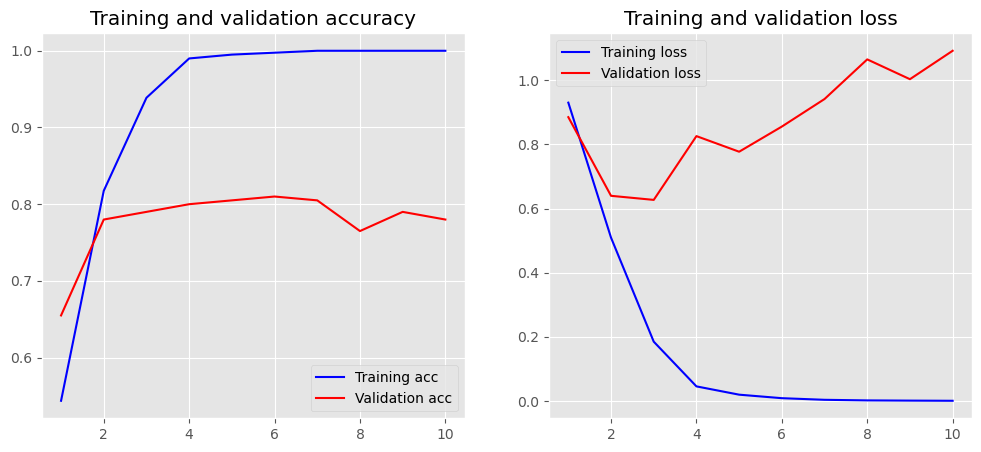

In [29]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc)+1)

  plt.figure(figsize=(12,5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label = 'Training acc')
  plt.plot(x, val_acc, 'r', label = 'Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label= 'Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

%matplotlib inline 
plot_history(history)

In [30]:
model.save('model.h5')
print("model saved")


model saved


In [33]:
from keras.models import load_model
import re 

def lower(text):
    return text.lower()

def rmv_unn(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def rmv_nonalpha(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

def preprocess(text):
    text = lower(text) # 1
    text = rmv_nonalpha(text) # 2
    text = rmv_unn(text) # 2
    return text

sentiment = ['negative', 'neutral', 'positive']
input_text = """ 
Pelayanan sangat baik sekali. 
"""
text = [preprocess(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print ("text: ", text[0])
print ("sentiment: ", sentiment[polarity])

2022-12-02 00:13:17.584796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 00:13:17.667493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 356ms/step
text:   pelayanan sangat baik sekali 
sentiment:  positive
